# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.24 which is incompatible.


In [2]:
#Main imports
from collections import deque
from collections import namedtuple
import copy

import json

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import random
from replays import ReplayBuffer

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from workspace_utils import active_session

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
from unityagents import UnityEnvironment

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {states.shape[0]} agents.  Each observes a state with length: {state_size}')
print(f'The state for the first agent looks like: {states[0]}')

Number of agents: 20
Size of each action: 4
There are 20 agents.  Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
#env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
#states = env_info.vector_observations                  # get the current state (for each agent)
#scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#while True:
#    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#    env_info = env.step(actions)[brain_name]           # send all actions to the environment
#    next_states = env_info.vector_observations         # get next state (for each agent)
#    rewards = env_info.rewards                         # get reward (for each agent)
#    dones = env_info.local_done                        # see if episode finished
#    scores += env_info.rewards                         # update the score (for each agent)
#    states = next_states                               # roll over states to next time step
#    if np.any(dones):                                  # exit loop if episode finished
#        break
#print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# Plotting Tool
The results are much more easily visualized with plots

In [20]:
def generate_plot(name: str, mode: str, scores: list, window: int=100, threshold: int=30) -> None:
    firstpass = np.where(np.array(scores) > threshold)[0]
    if firstpass is not None:
        print(f'First pass in Episode: {firstpass[0]}')
    else:
        print(f'Agent has not passed yet :(')
    score_series = pd.Series(scores)
    score_series.to_csv(f'{name}_first_{len(scores)}_scores.csv')
    windows = score_series.rolling(window)
    smoothedscores = windows.mean()
    firstave = np.where(np.array(smoothedscores) > threshold)[0]
    if firstave is not None:
        print(f'First full pass in Episode: {firstave[0]}')
    maxave = np.max(smoothedscores)
    maxind = smoothedscores.idxmax()
    print(f'Maximum Average Score: {maxave}')
    print(f'Maximum Episode Index: {maxind}')
    
    plt.plot(smoothedscores)
    if firstave is not None:
        plt.axvline(x=firstave[0])
    plt.axhline(y=threshold)
    plt.title(f'{name} with {mode} Experience Replay Average Scores')
    plt.xlabel('Episode')
    plt.ylabel(f'Average Score over {window} Episodes')
    plt.savefig(f'{name}_{mode}_Averages.png')
    return

In [7]:
# function to add to JSON, modified from the Geeks for Geeks article
# https://www.geeksforgeeks.org/append-to-json-file-using-python/
def write_json(new_data: dict, filename: str='experiments.json') -> None:
    if not os.path.exists(filename):
        print('initializing JSON file')
        with open(filename,'w') as jsonFile:
            nd = {'exp_details': [new_data]}
            json.dump(nd, jsonFile)
        return
    with open(filename,'r+') as file:
        print('updating JSON file')
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside exp_details
        file_data['exp_details'].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

In [8]:
#Version
v = 8

#Hyperparameters
BATCH_SIZE = 256        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
MU = 0.                 # Mu value for OU Noise
N_UPDATES = 10          # Number of updates to make every time the agent learns
SIGMA = 0.10            # Sigma value for OU Noise
TAU = 1e-3              # for soft update of target parameters
THETA = 0.15            # Theta value for OU Noise
UPDATE_EVERY = 20       # How often to do the learning
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
hypers = {'BATCH_SIZE': BATCH_SIZE, 'BUFFER_SIZE': BUFFER_SIZE, 'GAMMA': GAMMA, 'LR_ACTOR': LR_ACTOR, 'LR_CRITIC': LR_CRITIC, 
         'MU': MU, 'N_UPDATES': N_UPDATES, 'SIGMA': SIGMA, 'TAU': TAU, 'THETA': THETA, 'UPDATE_EVERY': UPDATE_EVERY, 
          'WEIGHT_DECAY': WEIGHT_DECAY}

In [10]:
#Hidden layer
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [11]:
#The first Actor/Policy 
class Actor(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int, fc1_units: int=400, fc2_units: int=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))  #tanh maps the full number line to (-1,+1)

In [12]:
#Now we define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int, fcs1_units: int=256, fc2_units: int=256, 
                 fc3_units: int=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)          
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [13]:
class OUNoise:
    """Ornstein-Uhlenbeck process"""
    def __init__(self, size: int, seed: int, mu: float=0., theta: float=0.15, sigma: float=0.20):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [14]:
#Agent copied & modified from Udacity DDPG-Bipedal Github repo
class DDPG_Agent():
    """Agent which interacts with the environment"""
    def __init__(self, state_size: int, action_size: int, hypers: dict, random_seed: int=37, filename: str=None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of distinct agents
            hypers (dict): dictionary defining all the hyperparameters
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.start_episode = 0
    
        self.hypers = hypers #Storing it here for use in save-step
        
        self.BATCH_SIZE = hypers['BATCH_SIZE']
        self.BUFFER_SIZE = hypers['BUFFER_SIZE']
        self.GAMMA = hypers['GAMMA']
        LR_ACTOR = hypers['LR_ACTOR']
        LR_CRITIC = hypers['LR_CRITIC']
        self.N_UPDATES = hypers['N_UPDATES']
        self.TAU = hypers['TAU']
        self.UPDATE_EVERY = hypers['UPDATE_EVERY']
        WEIGHT_DECAY = hypers['WEIGHT_DECAY']
        
        #Define a set of actor networks, each with a target network & dedicated optimizer
        self.actor_primary = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_primary.parameters(), lr=LR_ACTOR) 
        
        #Critic network with target network & dedicated optimizer
        self.critic_primary = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_primary.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed, hypers['MU'], hypers['THETA'], hypers['SIGMA'])

        # Replay memory --> Using uniform experience replay, might try prioritized at a later time
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, random_seed, device)
        
        # Time step: only update every UPDATE_EVERY
        self.t_step = 0
        
        if filename is not None:
            self._load_state(filename)
        
    def step(self, states, actions, rewards, next_states, dones) -> None:
        """Save experience in replay memory, and use random sample from buffer to learn."""
        #Push all the new entries into the replay buffer
        for state,action,reward,next_state,done in zip(states,actions,rewards,next_states,dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory learn N_UPDATES times
            if len(self.memory) > self.BATCH_SIZE:
                for _ in range(self.N_UPDATES):
                    experiences = self.memory.sample()
                    self.learn(experiences)        
            
    def act(self, state, add_noise: bool=True) -> None:
        """Returns actions for given states for all agents as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_primary.eval()
        with torch.no_grad():
            action = self.actor_primary(state).cpu().data.numpy()
        self.actor_primary.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences: tuple) -> None:
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions & Q values from the target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.GAMMA * Q_targets_next * (1 - dones))
        # Compute the expected Q values using the primary critic network
        Q_expected = self.critic_primary(states, actions)
        # Compute the critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the critic loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_primary.parameters(), 1) #Clip gradients for stability
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ------------------------------ #
        # Compute & Minimize Actor loss
        actions_pred = self.actor_primary(states)
        actor_loss = -self.critic_primary(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # -------------------- soft update target networks ----------------------- #
        self.soft_update()
        
    def soft_update(self):
        """Soft update model parameters.
        θ_target = τ * θ_primary + (1 - τ) * θ_target
        """
        #Update the Actor's target network
        for target_param, primary_param in zip(self.actor_target.parameters(), self.actor_primary.parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)

        #Update the Critic's target network
        for target_param, primary_param in zip(self.critic_target.parameters(), self.critic_primary.parameters()):
            target_param.data.copy_(self.TAU * primary_param.data + (1.0 - self.TAU) * target_param.data)
            
    def save_state(self, version: int, episodes):
        #Save the important details to a file to resume training later
        state = {'actor': self.actor_primary.state_dict(), 'critic': self.critic_primary.state_dict(),
                'actor_optimizer': self.actor_optimizer.state_dict(), 'critic_optimizer': self.critic_optimizer.state_dict(),
                'episodes': self.start_episode + episodes, 'version': version}
        torch.save(state, f'DDPG_v{version}_{self.start_episode + episodes}episodes.pth.tar')
        
    def _load_state(self, filename: str):
        #Taken & modified from:
        #https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/3
        if os.path.isfile(filename):
            print(f'Loading checkpoint: {filename}')
            checkpoint = torch.load(filename)
            self.start_episode += checkpoint['episodes']
            self.actor_primary.load_state_dict(checkpoint['actor'])
            self.actor_target.load_state_dict(checkpoint['actor'])
            self.critic_primary.load_state_dict(checkpoint['critic'])
            self.critic_target.load_state_dict(checkpoint['critic'])
            self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])
            self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
        else:
            print(f'{filename} is not a file!')

In [15]:
#Let's define the Training loop...
def train(agent, version: int, num_episodes: int, t_step_limit: int=1000) -> list:
    
    mainscores = []
    mainscore_window = deque(maxlen=100)
    episode_times = []
    start_time = time.perf_counter()
    for i in range(num_episodes):
        ep_start = time.perf_counter()
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
            
        agent.reset()                                          # Clears noise parameter
        
        for _ in range(t_step_limit):
            actions = agent.act(states)                            # Agent takes actions
            env_info = env.step(actions)[brain_name]               # send all actions to the environment
            next_states = env_info.vector_observations             # get next state (for each agent)
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            scores += env_info.rewards                             # update the score (for each agent) 
            
            agent.step(states,actions,rewards,next_states,dones)   # Agent takes a step, with all that entails
            
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
                
        mainscore_window.append(np.mean(scores))
        mainscores.append(np.mean(scores))
        ep_end = time.perf_counter()
        ept = ep_end - ep_start
        episode_times.append(ept)
        print(f'Episode: {i}, Episode Time: {ept: .3f}, Total Time: {(ep_end - start_time): .3f}')
        print(f'Average Score: {mainscores[-1]: .3f}')
        
    print(f'------------- Training Complete! ---------------')
    print(f'Maximum score: {max(mainscores): .3f}, in Episode: {mainscores.index(max(mainscores))}')
    save_path = f'DDPG_v{version}_{agent.start_episode + num_episodes}episodes.pth.tar'
    agent.save_state(version, num_episodes)
    
    clock_time = time.perf_counter() - start_time
    nd = {'version': version, 'save_path': save_path, 'hypers': agent.hypers, 'clock_time': clock_time, 
          'Episodes': num_episodes, 'final_score': mainscores[-1], 'max_score': max(mainscores)
         }
    write_json(nd)
        
    return mainscores

In [16]:
agent = DDPG_Agent(state_size, action_size, hypers)

In [17]:
with active_session():
    agentscores = train(agent, v, 300)
    generate_plot(f'DDPG_v{v}', 'Uniform', agentscores)

Episode: 0, Episode Time:  10.959, Total Time:  10.959
Average Score:  0.443
Episode: 1, Episode Time:  11.143, Total Time:  22.103
Average Score:  0.794
Episode: 2, Episode Time:  11.166, Total Time:  33.271
Average Score:  0.602
Episode: 3, Episode Time:  11.345, Total Time:  44.616
Average Score:  0.821
Episode: 4, Episode Time:  11.372, Total Time:  55.988
Average Score:  0.730
Episode: 5, Episode Time:  11.530, Total Time:  67.518
Average Score:  1.327
Episode: 6, Episode Time:  11.485, Total Time:  79.004
Average Score:  0.946
Episode: 7, Episode Time:  11.824, Total Time:  90.828
Average Score:  1.145
Episode: 8, Episode Time:  11.934, Total Time:  102.762
Average Score:  1.012
Episode: 9, Episode Time:  12.075, Total Time:  114.837
Average Score:  1.247
Episode: 10, Episode Time:  12.081, Total Time:  126.918
Average Score:  1.835
Episode: 11, Episode Time:  12.240, Total Time:  139.159
Average Score:  1.515
Episode: 12, Episode Time:  12.319, Total Time:  151.478
Average Score

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

First pass in Episode: 80
First full pass in Episode: 143
Maximum Average Score: 37.48743416209052
Maximum Episode Index: 233


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


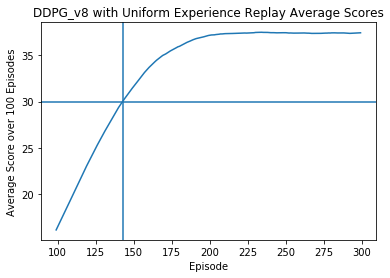

In [21]:
generate_plot(f'DDPG_v{v}', 'Uniform', agentscores)

In [19]:
#Quicktest cell -- save
testscores = train(agent, 999, 5)

Episode: 0, Episode Time:  25.836, Total Time:  25.836
Average Score:  0.953
Episode: 1, Episode Time:  26.288, Total Time:  52.125
Average Score:  0.826
Episode: 2, Episode Time:  26.578, Total Time:  78.703
Average Score:  1.146
Episode: 3, Episode Time:  26.910, Total Time:  105.614
Average Score:  1.087
Episode: 4, Episode Time:  27.216, Total Time:  132.830
Average Score:  1.169
------------- Training Complete! ---------------
Maximum score:  1.169, in Episode: 4
updating JSON file


In [24]:
#Quicktest cell -- load
newagent = DDPG_Agent(state_size, action_size, hypers, 37, 'DDPG_v999_5episodes.pth.tar')

Loading checkpoint: DDPG_v999_5episodes.pth.tar


In [25]:
#Quicktest cell -- continued training
newtestscore = train(newagent, 9999, 5)

Episode: 0, Episode Time:  24.551, Total Time:  24.551
Average Score:  1.593
Episode: 1, Episode Time:  25.179, Total Time:  49.731
Average Score:  1.594
Episode: 2, Episode Time:  25.123, Total Time:  74.854
Average Score:  1.676
Episode: 3, Episode Time:  25.242, Total Time:  100.097
Average Score:  2.259
Episode: 4, Episode Time:  25.403, Total Time:  125.500
Average Score:  2.399
------------- Training Complete! ---------------
Maximum score:  2.399, in Episode: 4
updating JSON file


# BUFFER CELL